<a href="https://colab.research.google.com/github/econb/data-science-mae/blob/main/stnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/wtding1998/STNN_nCov/blob/master/train_stnn.py


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pwd
%cd /content/drive/MyDrive/Colab Notebooks/STNN
!pwd

!pip install configargparse
!pip install torchinfo
import os
import pandas as pd
import result

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/STNN
/content/drive/MyDrive/Colab Notebooks/STNN
/content/drive/MyDrive/Colab Notebooks/STNN
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from train_stnn import get_opt, train_by_opt
from utils import DotDict

opt = DotDict({'datadir': 'data', 'dataset': 'Italy', 'nt_train': 250, 'nt_val': 10, 'data_normalize': 'x', 'relation_normalize': 'all', 'relations': 'all', 'time_datas': 'all', 'indicate_data': 'confirmed', 'outputdir': 'Italy', 'xp': 'stnn', 'xp_model': True, 'xp_time': True, 'model': 'classical', 'mode': 'default', 'nz': 3, 'activation': 'tanh', 'khop': 1, 'nhid': 20, 'nlayers': 2, 'nhid_de': 20, 'nlayers_de': 2, 'nhid_in': 0, 'nlayers_in': 1, 'dropout_f': 0, 'dropout_d': 0, 'dropout_de': 0, 'dropout_in': 0, 'wd': 1e-06, 'wd_z': 0.0001, 'l2_z': 0.0, 'l1_rel': 0.0, 'lambd': 1, 'lr': 0.001, 'optimizer': 'Adam', 'beta1': 0.9, 'beta2': 0.999, 'eps': 1e-08, 'nepoch': 10000, 'batch_size': 1000000, 'sample_method': 'uniform', 'validate': True, 'es_start': 2300, 'patience': 100, 'es_val_bound': 10000000.0, 'es_wd_factor': 0.1, 'reduce_start': 2300, 'reduce_factor': 0.1, 'test': True, 'train_meantime': False, 'device': -1, 'manualSeed': 2804, 'checkpoint_interval': 100, 'log': True, 'log_relations': False, 'run_min': False, 'show_fig': True})
#stnn_model = train_by_opt(opt)

In [ ]:
from torchinfo import summary
summary(stnn_model)

Layer (type:depth-idx)                   Param #
SaptioTemporalNN_classical               --
├─Dropout: 1-1                           --
├─MLP_tanh: 1-2                          --
│    └─Sequential: 2-1                   --
│    │    └─Linear: 3-1                  80
│    │    └─Tanh: 3-2                    --
│    │    └─Dropout: 3-3                 --
│    │    └─Linear: 3-4                  63
├─MLP_tanh: 1-3                          --
│    └─Sequential: 2-2                   --
│    │    └─Linear: 3-5                  80
│    │    └─Tanh: 3-6                    --
│    │    └─Dropout: 3-7                 --
│    │    └─Linear: 3-8                  21
Total params: 244
Trainable params: 244
Non-trainable params: 0

In [ ]:
print(stnn_model)

SaptioTemporalNN_classical(
  (drop): Dropout(p=0, inplace=False)
  (dynamic): MLP_tanh(
    (module): Sequential(
      (0): Linear(in_features=3, out_features=20, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=20, out_features=3, bias=True)
    )
  )
  (decoder): MLP_tanh(
    (module): Sequential(
      (0): Linear(in_features=3, out_features=20, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=20, out_features=1, bias=True)
    )
  )
)


Summarize the given PyTorch model. Summarized information includes:
    1) Layer names,
    2) input/output shapes,
    3) kernel shape,
    4) # of parameters,
    5) # of operations (Mult-Adds)

NOTE: If neither input_data or input_size are provided, no forward pass through the
network is performed, and the provided model information is limited to layer names.


In [ ]:
 #-*-coding:utf-8 -*-

import os
import random
import json
from collections import defaultdict
import datetime

import configargparse
import numpy as np
from tqdm import trange
import torch
import torch.nn.functional as F
import torch.optim as optim

from get_dataset import get_stnn_data, get_true_indicate
from utils import DotDict, Logger, rmse, boolean_string, get_dir, get_time, time_dir, rmse_sum_confirmed, sample
from stnn import SaptioTemporalNN_classical, SaptioTemporalNN_A, SaptioTemporalNN_I
import result

opt = DotDict({'datadir': 'data', 'dataset': 'Italy', 'nt_train': 250, 'nt_val': 10, 'data_normalize': 'x', 'relation_normalize': 'all', 'relations': 'all', 'time_datas': 'all', 'indicate_data': 'confirmed', 'outputdir': 'Italy', 'xp': 'stnn', 'xp_model': True, 'xp_time': True, 'model': 'classical', 'mode': 'default', 'nz': 3, 'activation': 'tanh', 'khop': 1, 'nhid': 20, 'nlayers': 2, 'nhid_de': 20, 'nlayers_de': 2, 'nhid_in': 0, 'nlayers_in': 1, 'dropout_f': 0, 'dropout_d': 0, 'dropout_de': 0, 'dropout_in': 0, 'wd': 1e-06, 'wd_z': 0.0001, 'l2_z': 0.0, 'l1_rel': 0.0, 'lambd': 1, 'lr': 0.001, 'optimizer': 'Adam', 'beta1': 0.9, 'beta2': 0.999, 'eps': 1e-08, 'nepoch': 10000, 'batch_size': 1000000, 'sample_method': 'uniform', 'validate': True, 'es_start': 2300, 'patience': 100, 'es_val_bound': 10000000.0, 'es_wd_factor': 0.1, 'reduce_start': 2300, 'reduce_factor': 0.1, 'test': True, 'train_meantime': False, 'device': -1, 'manualSeed': 2804, 'checkpoint_interval': 100, 'log': True, 'log_relations': False, 'run_min': False, 'show_fig': True})

# path of output directory
opt.outputdir = get_dir(opt.outputdir)
if opt.xp_model:
    opt.xp = opt.xp + '-' + opt.model
if opt.xp_time:
    opt.xp = opt.xp + "_" + get_time()
# mode
opt.mode = opt.mode if opt.mode in ('refine', 'discover') else None
# log time
opt.start = time_dir()
start_st = datetime.datetime.now()
opt.st = datetime.datetime.now().strftime('%y-%m-%d-%H-%M-%S')
# cudnn
if opt.device > -1:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(opt.device)
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
# seed
if opt.manualSeed is None:
    opt.manualSeed = random.randint(1, 10000)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)
if opt.device > -1:
    torch.cuda.manual_seed_all(opt.manualSeed)

#######################################################################################################################
# Data
#######################################################################################################################
# -- load data
setup, (train_data, no_train_data, validation_data), relations = get_stnn_data(opt.datadir, opt.dataset, opt.nt_train, opt.khop, data_normalize=opt.data_normalize, relation_normalize=opt.relation_normalize, nt_val=opt.nt_val , relations_names=opt.relations, time_datas=opt.time_datas)
test_data = no_train_data[opt.nt_val:]
test_data = test_data.to(device)
train_data = train_data.to(device)
relations = relations.to(device)
validation_data = validation_data.to(device)
# -- load option
for k, v in setup.items():
    opt[k] = v
# --- get true validation
true_validation = get_true_indicate(validation_data, opt, indicate_data=opt.indicate_data).to(device)
# -- train inputs
t_idx = torch.arange(opt.nt_train, out=torch.LongTensor()).unsqueeze(1).expand(opt.nt_train, opt.nx).contiguous()
x_idx = torch.arange(opt.nx, out=torch.LongTensor()).expand_as(t_idx).contiguous()
# decoder
idx_dec = torch.stack((t_idx, x_idx)).view(2, -1).to(device)
nex_dec = idx_dec.size(1)


In [ ]:
setup

{'data_normalize': 'x',
 'datas_order': ['confirmed'],
 'mean': [1122.988037109375,
  214.45199584960938,
  502.0559997558594,
  4868.51220703125,
  5860.5517578125,
  816.8759765625,
  5100.6162109375,
  1798.7640380859375,
  19409.140625,
  1550.6600341796875,
  155.73599243164062,
  721.1439819335938,
  610.2999877929688,
  6478.02392578125,
  1967.9200439453125,
  994.1480102539062,
  2191.2080078125,
  3979.424072265625,
  689.0880126953125,
  225.03599548339844,
  5065.30419921875],
 'nd': 1,
 'normalize': 'variance',
 'nt': 275,
 'nt_val': 10,
 'nx': 21,
 'periode': 275,
 'relations_order': ['location', 'migration', 'distance_region'],
 'std': [1453.88134765625,
  363.05914306640625,
  725.431884765625,
  10320.388671875,
  5870.447265625,
  1120.4708251953125,
  7807.59033203125,
  2108.5869140625,
  18492.802734375,
  1648.27490234375,
  221.07861328125,
  1218.29931640625,
  669.5475463867188,
  8078.73291015625,
  2689.14013671875,
  1522.7864990234375,
  3386.7900390625,
  

In [ ]:
#relations, (21,3,21)
#opt.nx, num. individuals
#opt.nt_train, times for training
#opt.nd, 
#opt.nz, 
#opt.mode, 
#opt.nhid, 
#opt.nlayers,
#opt.nhid_de, 
#opt.nlayers_de, 
#opt.dropout_f, 
#opt.dropout_d, 
#opt.activation, 
#opt.periode

model = SaptioTemporalNN_classical(relations, opt.nx, opt.nt_train, opt.nd, opt.nz, opt.mode, opt.nhid, opt.nlayers,
                                  opt.nhid_de, opt.nlayers_de, opt.dropout_f, opt.dropout_d, opt.activation, opt.periode).to(device)
idx_dyn = torch.stack((t_idx[1:], x_idx[1:])).view(2, -1).to(device)
nex_dyn = idx_dyn.size(1)
params = [{'params': model.factors_parameters(), 'weight_decay': opt.wd_z},
      {'params': model.dynamic.parameters()},
      {'params': model.decoder.parameters()}]

## Training

In [ ]:
run train_stnn.py --outputdir Italy --model classical --dataset Italy --lr 1e-3 --manualSeed 2804 --nhid 20 --nlayers 2 --nhid_de 20 --nlayers_de 2  --wd_z 1e-4 --nz 3  --nt_train 250 --nt_val 10 --es_start 2300 --reduce_start 2300 --show True

In [ ]:
run train_stnn.py --outputdir Italy --model A --dataset Italy --lr 1e-3 --manualSeed 2816 --nhid 20 --nlayers 2 --nhid_de 20 --nlayers_de 2 --wd_z 5e-5 --nz 3  --nt_train 250 --nt_val 10 --es_start 2400 --reduce_start 2400 --show True

In [ ]:
run train_stnn.py --outputdir Italy --model I --dataset Italy --lr 1e-3 --manualSeed 6302 --nhid 20 --nlayers 2 --nhid_de 20 --nlayers_de 2 --nhid_in 20 --nlayers_in 2 --wd_z 1e-4 --nz 3  --nt_train 250 --nt_val 10 --es_start 3500 --reduce_start 3500 --show True

## Result

In [ ]:
Italy_result_dir = "./output/Italy"
Italy_result = result.FolderResult(Italy_result_dir)
Italy_result_df = Italy_result.get_result_df(col=['test_sum_score', 'test_rmse_score', 'val_sum_score', 'val_rmse_score'])
Italy_result_df

Load stnn-classical model.
Load stnn-A model.
Load stnn-I model.


,test_sum_score,test_rmse_score,val_sum_score,val_rmse_score
stnn-classical_08-05-21-11-40_6638,13284,57607.1,36812.9,30069.2
stnn-A_08-05-21-15-28_9644,14794.7,43236.9,23727.2,10612.5
stnn-I_08-05-21-26-55_5063,20643.6,42396.1,10249.6,7172.11


Load stnn-classical model.
Load stnn-A model.
Load stnn-I model.
Italy


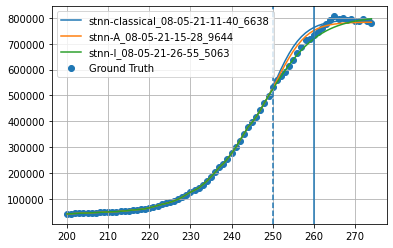

In [ ]:
Italy_result.plot_fitting(start_time=200)